## Семинар 7: "Методы оптимизации"

ФИО:

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.autograd import Variable
%matplotlib inline

import seaborn as sns

На этом семинаре мы попробуем сравнить различные методы оптимизации: GD, Momentum, NAG, Adagrad, Adadelta, Adam.

### Часть 1: Реализация методов

Полезная функция: plt.contour
Для всех экспериментов подберите параметры так, чтобы метод сошелся к ближайшему локальному минимуму. Все методы следует запускать из одной и той же точки.

<i> 1.1 Реализуйте методы GD, Momentum, NAG, Adagrad, Adadelta, Adam.</i>

In [0]:
import abc

class Optimizer(abc.ABC):
  def __init__(self, list_params):
    self.params = list(list_params)
  
  def step(self, err):
    pass

  def finish(self):
    with torch.no_grad():
        for param in self.params:
            param.grad.data.zero_()

class GD(Optimizer):
  def __init__(self, list_params, learning_rate):
    super().__init__(list_params)

    self.learning_rate = learning_rate

  def step(self, err):
    loss = err()
    loss.backward()

    with torch.no_grad():
      for param in self.params:
        param -= self.learning_rate * param.grad

    self.finish()

class Momentum(GD):
  def __init__(self, list_params, learning_rate, nu=0.1):
    super().__init__(list_params, learning_rate)

    self.nu = nu

    self.vs = [torch.zeros_like(param) for param in self.params]

  def step(self, err):
    loss = err()
    loss.backward()

    with torch.no_grad():
      for v, param in zip(self.vs, self.params):
        v.copy_(self.nu * v + self.learning_rate * param.grad)                

        param -= v

    self.finish()

class NAG(GD):
  def __init__(self, list_params, learning_rate, nu=0.1):
    super().__init__(list_params, learning_rate)

    self.nu = nu

    self.vs = [torch.zeros_like(param) for param in self.params]

  def step(self, err):
    with torch.no_grad():
      for v, param in zip(self.vs, self.params):
        param -= self.nu * v

    loss = err()
    loss.backward()

    with torch.no_grad():
      for v, param in zip(self.vs, self.params):
        param += self.nu * v

        v.copy_(self.nu * v + self.learning_rate * param.grad)        

        param -= v

    self.finish()

class RMSProp(GD):
  def __init__(self, list_params, learning_rate, gamma=0.9):
    super().__init__(list_params, learning_rate)

    self.gamma = gamma

    self.g_sq_list = [torch.zeros_like(param) for param in self.params]

    self.eps = 10**-8

  def step(self, err):
    loss = err()
    loss.backward()

    with torch.no_grad():
      for g_sq, param in zip(self.g_sq_list, self.params):
        g_sq.copy_(self.gamma * g_sq + (1 - self.gamma) * param.grad**2)
        
        param -= self.learning_rate * param.grad / (g_sq + self.eps)**0.5

    self.finish()

class Adadelta(Optimizer):
  def __init__(self, list_params, gamma=0.9):
    super().__init__(list_params)

    self.gamma = gamma

    self.params_delta = torch.ones(1)
    self.params_delta *= self.gamma**2

    self.g_sq_list = [torch.zeros_like(param) for param in self.params]

    self.eps = 10**-8

  def step(self, err):
    loss = err()
    loss.backward()

    with torch.no_grad():
      delta_sum = 0
      delta_params = 0
      current_learning_rate = self.params_delta.sqrt().item()
      for g_sq, param in zip(self.g_sq_list, self.params):    
        g_sq.copy_(self.gamma * g_sq + (1 - self.gamma) * param.grad**2)
        

        delta = current_learning_rate * param.grad / (g_sq + self.eps)**0.5    
        param -= delta

        delta_sum += (delta**2).sum().item()
        delta_params += delta.numel()

      delta_sum /= delta_params
      self.params_delta.copy_(self.gamma * self.params_delta + (1 - self.gamma) * delta_sum)

    self.finish()

In [3]:
type(np.array([0]))

numpy.ndarray

In [0]:
def J(x, y):
  return x**2 + y**2

def J(x, y):
  if isinstance(x, np.ndarray):
    return x**2 * np.sin(x) + y**2 * np.sin(y)
  else:
    return x**2 * x.sin() + y**2 * y.sin()

"""
def J(x, y):
  return x**2 - y**2
"""

def J(x, y):
  if isinstance(x, np.ndarray):
    return x**2 * np.sin(x**2) + y**2 * np.sin(y**2)
  else:
    return x**2 * ((x**2).sin()) + y**2 * ((y**2).sin())

In [13]:
def make_var(x):
  x = np.array([float(x)])
  x = torch.from_numpy(x)
  return torch.autograd.Variable(x, requires_grad=True)

x, y = make_var(1), make_var(2)

def err(J=J, x=x, y=y):
  return J(x, y)

learning_rate = 0.00001

optimizers = [
  GD([x, y], learning_rate),
  Momentum([x, y], learning_rate),
  NAG([x, y], learning_rate),
  #RMSProp([x, y], learning_rate),
  Adadelta([x, y])
]

all_points = []

for optim in optimizers:
  with torch.no_grad():
    x.copy_(torch.tensor(-6.0))
    y.copy_(torch.tensor(2))

  points = []

  for i in range(200):
    points.append((x.item(), y.item()))
    optim.step(err)
    #points.append((x.item(), y.item()))

  print(err())

  points = np.array(points)
  all_points.append(points)

tensor([-39.5162], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([-39.5523], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([-39.5523], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([-124.4197], dtype=torch.float64, grad_fn=<AddBackward0>)


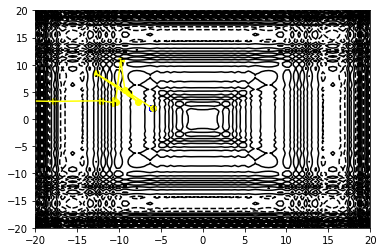

In [14]:
for points, color in zip(all_points, ["r", "g", "b", "yellow"]):
  plt.scatter(points[:, 0], points[:, 1], c=color)
  plt.plot(points[:, 0], points[:, 1], c=color)

size = 20

X = np.linspace(-size, size, 100)
Y = np.linspace(-size, size, 100)

X, Y = np.meshgrid(X, Y)
Z = J(X, Y)

plt.contour(X, Y, Z, colors='k')

axes = plt.gca()
axes.set_xlim([-size, size])
axes.set_ylim([-size, size])

plt.show()

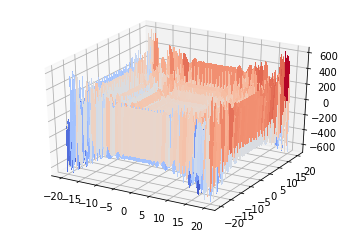

In [0]:
fig = plt.figure()
ax = fig.gca(projection='3d')

ax.plot_surface(X, Y, Z, cmap=plt.cm.coolwarm, linewidth=0, antialiased=False)

<i> 1.2 Сравните эти методы на функции $J(x, y) = x^2+y^2$</i>

In [0]:
f = lambda X: X[0]**2+X[1]**2
df = lambda X: np.array([2*X[0], 2*X[1]])



<i>1.3 Сравните эти методы на функции $J(x, y) = x^2sin(x)+y^2sin(y)$</i>

<i>1.3 Сравните эти методы на функции $J(x,y)=x^2sin(x^2)+y^2sin(y^2)$</i>

###  Часть 2: Обучение нейронной сети

<i> 2.1 Сравните графики обучения для полносвязной нейросети на методах Adam, Adagrad, AdaDelta и SGD (на MNIST). </i>

<i> 2.2 Сравните графики обучения для сверточной нейросети на методах Adam, Adagrad, AdaDelta и SGD. </i>

#### Feedback (опционально)

Здесь вы можете оставить список опечаток из лекции или семинара:

Здесь вы можете оставить комментарии по лекции или семинару: